## ***Kaggle's Team name:* Valeria_Selchonok_135450461**
### Получившийся score на Kaggle - 0.98724

# Задание. Классификация изображений

Как мы знаем, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании нам необходимо классифицировать персонажей, проживающих в Спрингфилде.


### Установка зависимостей

In [ ]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import PIL
print(PIL.__version__)

11.0.0


Скачиваю архив с каггла, загружаю себе на диск и монтирую к google colab

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/MyDrive/DLS_autumn_24/sem_7/journey-springfield.zip

In [ ]:
!ls train

simpsons_dataset


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Tue Nov 26 20:20:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

В нашем тесте будет 990 картинок, для которых нам будет необходимо предсказать класс.

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следует привести их к одному размеру

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')

In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

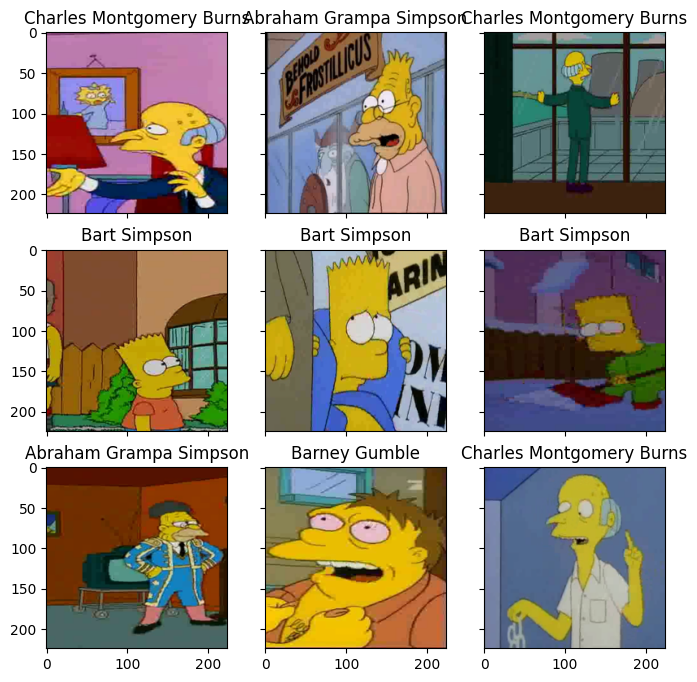

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение нейросети

Данная архитектура будет очень простой и нужна для того, чтобы получить простенький сабмит на Kaggle

*Описание слоев*:


1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [ ]:
# Очень простая сеть
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
# simple_cnn = SimpleCnn(n_classes).to(DEVICE)
simple_cnn = SimpleCnn(n_classes).to(device)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

Запустим обучение сети.

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 2.5727532265467117


epoch:  50%|█████     | 1/2 [02:13<02:13, 133.80s/it]


Epoch 001 train_loss: 2.5728     val_loss 1.9676 train_acc 0.2876 val_acc 0.4624
loss 1.5213356326967222


epoch: 100%|██████████| 2/2 [04:21<00:00, 130.88s/it]


Epoch 002 train_loss: 1.5213     val_loss 1.3293 train_acc 0.5874 val_acc 0.6506


Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

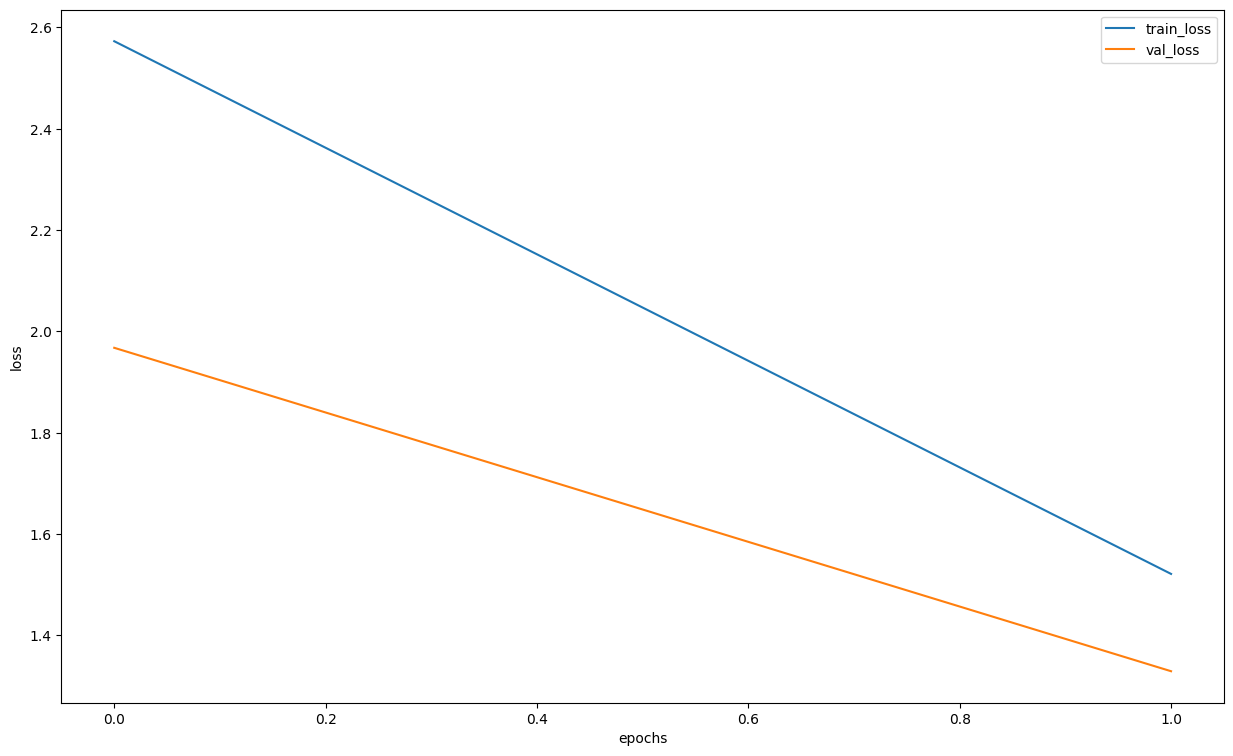

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Ну, такое себе... Да, эпох совсем мало, но уже есть гипотеза, что результаты стоит улучшать более сложными моделями

Пробуем сделать самбит

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Метрика, которую необходимо оптимизировать в конкурсе, -- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)


F1-оценка: 0.55


Явно нужно будет что-то делать другое

Сделаем классную визуализацию,  чтобы посмотреть, насколько сеть уверена в своих ответах.

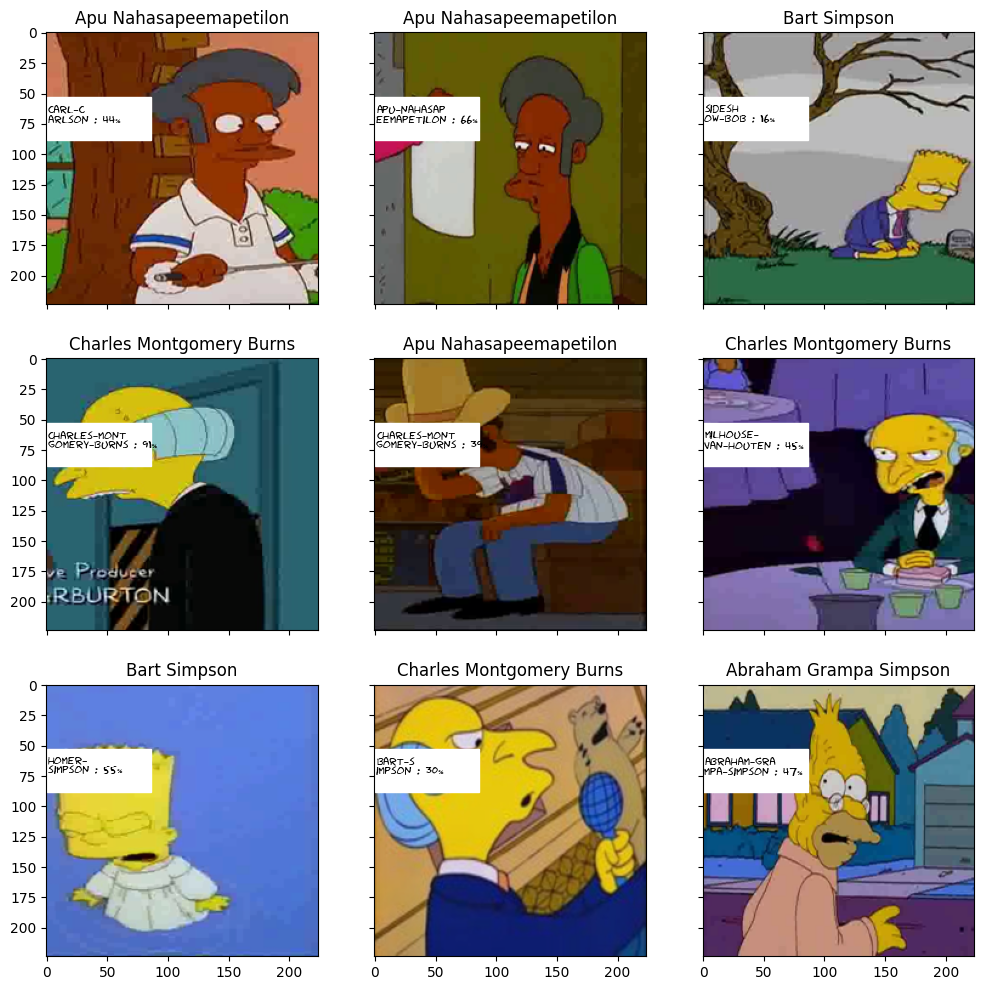

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Некоторые персонажи встречаются сильно реже других. Что ж, окей, будем балансировать классы

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128)

In [ ]:
! ls

characters_illustration.png  label_encoder.pkl	sample_submission.csv  train
gdrive			     sample_data	testset


In [ ]:
import pandas as pd
my_submit = pd.read_csv("/content/sample_submission.csv")
# my_submit = pd.DataFrame({'Image_id': file_names, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [ ]:
my_submit_v2 = pd.DataFrame(
    {'Id': test_filenames, 'Expected': preds
     }).to_csv('simple_cnn_baseline_2.csv', index=False)

In [ ]:
my_submit.to_csv('simple_cnn_baseline.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Что ж...
Запустим transfer learning)

Попробуем *ResNet18*. Почти наверняка и другие, более тяжёлые модели работают неплохо, но в силу ограниченности времени доступной GPU я решила по возможности более тяжёлые варианты не рассматривать.

In [ ]:
# num_features = 512
# # Заменяем Fully-Connected слой на наш линейный классификатор
# model.last_linear = nn.Linear(num_features, 42)

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os

In [ ]:
trainloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=2
)

testloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=100,
    shuffle=False,
    num_workers=2
)

In [ ]:
trainloader

In [ ]:
from IPython.display import clear_output
import numpy as np

In [ ]:
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)

А вот теперь начинается интересное.
Постаралась комментариями отметить основные моменты

### Попытка №1. Замораживаем всё, кроме FC-слоя и последнего слоя


In [ ]:
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.models as models
from sklearn.metrics import f1_score

# Constants
BATCH_SIZE = 128 
NUM_EPOCHS = 15   # чтобы попробовать много разных моделей
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATIENCE = 5  # играет позже -
# этот параметр = минимально возможный номер эпохи, на которой модель
# заканчивает обучаться в случае быстрого переобучения, и он же - максимальное
# количество эпох, которое может пройти от эпохи с минимальным loss'ом
NUM_CLASSES = 42

def get_model():   # загружаем ResNet18
    model = models.resnet18(pretrained=True)
    for param in list(model.parameters())[:-2]:  # замораживаем все слои,
    # кроме последних двух (точнее, 1 слой + FC-слой)
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)  # меняем количество
    # выходных классов на то, сколько у нас классов в Симпсонах
    return model.to(DEVICE)

class EarlyStopping:  # класс для остановки модели на более ранней эпохе
# в случае переобучения. дефолтный patience=7
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def train_model(model, train_loader, val_loader):
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam([
        {'params': model.fc.parameters(), 'lr': 1e-3},
        {'params': list(model.parameters())[:-2], 'lr': 1e-5}
    ])  # на обучаемых слоях делаем lr относительно большим,
    # на FC-слое - поменьше

    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1,
                                  patience=3, verbose=True)  # уменьшаем lr,
    # когда градиенты "выходят на плато" (практически перестают меняться)
    early_stopping = EarlyStopping(patience=PATIENCE)
    best_val_f1 = 0.0

    for epoch in range(NUM_EPOCHS):
        print(f'\nEpoch {epoch+1}/{NUM_EPOCHS}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        train_predictions = []
        train_labels = []

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_predictions.extend(outputs.argmax(dim=1).cpu().numpy())
            train_labels.extend(targets.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_f1 = f1_score(train_labels, train_predictions, average='weighted')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_predictions = []
        val_labels = []

        with torch.no_grad():  # не обучаем модель на валидации
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                val_predictions.extend(outputs.argmax(dim=1).cpu().numpy())
                val_labels.extend(targets.cpu().numpy())

        val_loss = val_loss / len(val_loader)
        val_f1 = f1_score(val_labels, val_predictions, average='weighted')

        print(f'Train Loss: {train_loss:.4f} Train F1: {train_f1:.4f}')
        print(f'Val Loss: {val_loss:.4f} Val F1: {val_f1:.4f}')

        scheduler.step(val_f1)
        early_stopping(val_loss)  # смотрим, нужно ли выходить или учиться

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save({  # на каждой эпохе сохраняем лучшую модель из имеющихся
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_f1': best_val_f1,
            }, 'best_model.pth')

        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    return model

def predict(model, test_loader):
    model.eval()
    predictions = []

    with torch.no_grad():  # не обучаем на тесте
        for inputs in test_loader:
            if isinstance(inputs, tuple):  # проверяем, нужного ли формата ввод
                inputs = inputs[0]
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            predictions.extend(outputs.argmax(dim=1).cpu().numpy())

    return predictions

In [ ]:
# Create data loaders
train_loader = DataLoader(
    dataset=SimpsonsDataset(train_files, mode='train'),
    batch_size=128,
    shuffle=True
)

val_loader = DataLoader(
    dataset=SimpsonsDataset(val_files, mode='val'),
    batch_size=128,
    shuffle=False
)

Теперь учим

In [ ]:
model = get_model()
model = train_model(model, train_loader, val_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/15
----------
Train Loss: 2.4272 Train F1: 0.3771
Val Loss: 1.8302 Val F1: 0.5390

Epoch 2/15
----------
Train Loss: 1.5382 Train F1: 0.6187
Val Loss: 1.4116 Val F1: 0.6411

Epoch 3/15
----------
Train Loss: 1.2351 Train F1: 0.6823
Val Loss: 1.2133 Val F1: 0.6800

Epoch 4/15
----------
Train Loss: 1.0747 Train F1: 0.7203
Val Loss: 1.1110 Val F1: 0.7084

Epoch 5/15
----------
Train Loss: 0.9709 Train F1: 0.7452
Val Loss: 1.0435 Val F1: 0.7168

Epoch 6/15
----------
Train Loss: 0.9000 Train F1: 0.7607
Val Loss: 1.0230 Val F1: 0.7234

Epoch 7/15
----------
Train Loss: 0.8486 Train F1: 0.7745
Val Loss: 0.9645 Val F1: 0.7381

Epoch 8/15
----------
Train Loss: 0.8027 Train F1: 0.7841
Val Loss: 0.9483 Val F1: 0.7413

Epoch 9/15
----------
Train Loss: 0.7732 Train F1: 0.7930
Val Loss: 0.9238 Val F1: 0.7465

Epoch 10/15
----------
Train Loss: 0.7431 Train F1: 0.8012
Val Loss: 0.9147 Val F1: 0.7540

Epoch 11/15
----------
Train Loss: 0.7137 Train F1: 0.8111
Val Loss: 0.8965 Val F1: 0.75

Получше, конечно, чем SimpleNet, но как-то всё ещё не густо(

In [ ]:
# Make predictions
predictions = predict(model, test_loader)

# Convert numerical predictions back to labels
with open('label_encoder.pkl', 'rb') as le_file:
    label_encoder = pickle.load(le_file)

predicted_labels = label_encoder.inverse_transform(predictions)

In [ ]:
import pandas as pd

my_submit_v0 = pd.DataFrame({
    'Id': test_files,
    'Expected': predicted_labels
})
my_submit_v0.to_csv('solution_v0.csv', index=False)

### Попытка №2. Оставляем FC-слой и добавляем балансировку классов

Модифицируем сеть:

1) замораживаем только первый слой (FC)

2) вспоминаем о балансировке классов

3) делаем lr-scheduler более плавным: была идея, что lr в какой-то момент упал слишком сильно, отчего сеть хуже обучалась на поздних эпохах

In [ ]:
BATCH_SIZE = 128
NUM_EPOCHS = 15
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATIENCE = 5
NUM_CLASSES = 42

def get_model():
    model = models.resnet18(pretrained=True)
    # не замораживаем только первый слой (FC)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    model.fc.requires_grad = True
    return model.to(DEVICE)

def get_sampler(dataset):
    # создаём массив меток классов
    labels = [dataset[i][1] for i in range(len(dataset))]

    # считаем веса классов
    class_counts = torch.bincount(torch.tensor(labels))
    weights = 1.0 / class_counts.float()

    sample_weights = [weights[label] for label in labels]

    sampler = WeightedRandomSampler(  # балансировка классов
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    return sampler

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def train_model(model, train_loader, val_loader):
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam([
        {'params': model.fc.parameters(), 'lr': 1e-3}
    ])

    # Gentler learning rate scheduler
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=0.5,  # Less aggressive reduction
        patience=5,   # Wait longer before reducing
        verbose=True,
        min_lr=1e-6
    )

    early_stopping = EarlyStopping(patience=PATIENCE)
    best_val_f1 = 0.0

    for epoch in range(NUM_EPOCHS):
        print(f'\nEpoch {epoch+1}/{NUM_EPOCHS}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        train_predictions = []
        train_labels = []

        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_predictions.extend(outputs.argmax(dim=1).cpu().numpy())
            train_labels.extend(targets.cpu().numpy())


        train_loss = running_loss / len(train_loader)
        train_f1 = f1_score(train_labels, train_predictions, average='weighted')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_predictions = []
        val_labels = []

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                val_predictions.extend(outputs.argmax(dim=1).cpu().numpy())
                val_labels.extend(targets.cpu().numpy())

        val_loss = val_loss / len(val_loader)
        val_f1 = f1_score(val_labels, val_predictions, average='weighted')

        print(f'Train Loss: {train_loss:.4f} Train F1: {train_f1:.4f}')
        print(f'Val Loss: {val_loss:.4f} Val F1: {val_f1:.4f}')

        # Learning rate scheduling based on validation F1
        scheduler.step(val_f1)

        early_stopping(val_loss)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_f1': best_val_f1,
            }, 'best_model.pth')

        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    writer.close()
    return model

def predict(model, test_loader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for inputs in test_loader:
            if isinstance(inputs, tuple):
                inputs = inputs[0]
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            predictions.extend(outputs.argmax(dim=1).cpu().numpy())

    return predictions

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

trainloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=get_sampler(train_dataset),
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

In [ ]:
# снова учим
model = get_model()
model = train_model(model, trainloader, val_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/15
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Loss: 2.5867 Train F1: 0.4358
Val Loss: 2.3776 Val F1: 0.4705

Epoch 2/15
----------
Train Loss: 1.4498 Train F1: 0.7308
Val Loss: 1.7307 Val F1: 0.6321

Epoch 3/15
----------
Train Loss: 1.0661 Train F1: 0.7934
Val Loss: 1.4724 Val F1: 0.6727

Epoch 4/15
----------
Train Loss: 0.8844 Train F1: 0.8176
Val Loss: 1.3092 Val F1: 0.6980

Epoch 5/15
----------
Train Loss: 0.7583 Train F1: 0.8404
Val Loss: 1.2967 Val F1: 0.6853

Epoch 6/15
----------
Train Loss: 0.6828 Train F1: 0.8544
Val Loss: 1.2047 Val F1: 0.7025

Epoch 7/15
----------
Train Loss: 0.6280 Train F1: 0.8643
Val Loss: 1.1223 Val F1: 0.7189

Epoch 8/15
----------
Train Loss: 0.5800 Train F1: 0.8740
Val Loss: 1.1136 Val F1: 0.7199

Epoch 9/15
----------
Train Loss: 0.5607 Train F1: 0.8752
Val Loss: 1.0474 Val F1: 0.7395

Epoch 10/15
----------
Train Loss: 0.5039 Train F1: 0.8867
Val Loss: 1.0377 Val F1: 0.7412

Epoch 11/15
----------
Train Loss: 0.4944 Train F1: 0.8866
Val Loss: 1.0288 Val F1: 0.7379

Epoch 12/15
-------

Помогло, но не сказать чтобы сильно...
Кроме того, похоже, сеть стала достаточно сильно переобучаться - начинает быть существенным отличие в f1-score между тренировочной и валидационной выборками.

(предикты всё равно сохраняю)

In [ ]:
# Predictions
predictions = predict(model, testloader)

In [ ]:
with open('label_encoder.pkl', 'rb') as le_file:
    label_encoder = pickle.load(le_file)

predicted_labels = label_encoder.inverse_transform(predictions)

# заметила, что название картинок в предикте не совсем корректное,
# поэтому чищу пути от названия папок
clean_file_names = [path.name for path in test_files]

my_submit_v1 = pd.DataFrame({
    'Id': clean_file_names,
    'Expected': predicted_labels
})
my_submit_v1.to_csv('solution_v1.csv', index=False)

### Попытка №3. Добавление аугментаций

Следующая итерация модификации сети:

Боремся с переобучением: добавляем аугментации в данные, меняя *\_\_getitem\_\_* (не делала сразу, т.к. читала очень разные комментарии в сети о результативности использования)

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
      x = self.load_sample(self.files[index])
      x = self._prepare_sample(x)

      # добавляем много разных аугментаций для трейна
      if self.mode == 'train':
        transform = transforms.Compose([
            transforms.ToPILImage(),  # Convert numpy array to PIL Image
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
      else:  # для теста оставляем только то, что уже было
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

      x = np.array(x / 255, dtype='float32')
      x = transform(x)

      if self.mode == 'test':
        return x
      else:
        label = self.labels[index]
        label_id = self.label_encoder.transform([label])
        y = label_id.item()
        return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
BATCH_SIZE = 128
NUM_EPOCHS = 15
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATIENCE = 5
NUM_CLASSES = 42

def get_model():
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    model.fc.requires_grad = True
    return model.to(DEVICE)

def get_sampler(dataset):
    labels = [dataset[i][1] for i in range(len(dataset))]

    class_counts = torch.bincount(torch.tensor(labels))
    weights = 1.0 / class_counts.float()

    sample_weights = [weights[label] for label in labels]

    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    return sampler

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def train_model(model, train_loader, val_loader):
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam([
    {'params': model.fc.parameters(), 'lr': 1e-3}
    ], weight_decay=1e-4)

    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=0.5,
        patience=5,
        verbose=True,
        min_lr=1e-6
    )

    early_stopping = EarlyStopping(patience=PATIENCE)
    best_val_f1 = 0.0

    for epoch in range(NUM_EPOCHS):
        print(f'\nEpoch {epoch+1}/{NUM_EPOCHS}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        train_predictions = []
        train_labels = []

        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_predictions.extend(outputs.argmax(dim=1).cpu().numpy())
            train_labels.extend(targets.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_f1 = f1_score(train_labels, train_predictions, average='weighted')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_predictions = []
        val_labels = []

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                val_predictions.extend(outputs.argmax(dim=1).cpu().numpy())
                val_labels.extend(targets.cpu().numpy())

        val_loss = val_loss / len(val_loader)
        val_f1 = f1_score(val_labels, val_predictions, average='weighted')

        print(f'Train Loss: {train_loss:.4f} Train F1: {train_f1:.4f}')
        print(f'Val Loss: {val_loss:.4f} Val F1: {val_f1:.4f}')

        scheduler.step(val_f1)

        early_stopping(val_loss)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_f1': best_val_f1,
            }, 'best_model.pth')

        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    writer.close()
    return model

def predict(model, test_loader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for inputs in test_loader:
            if isinstance(inputs, tuple):
                inputs = inputs[0]
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            predictions.extend(outputs.argmax(dim=1).cpu().numpy())

    return predictions

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

trainloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=get_sampler(train_dataset),
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

In [ ]:
# учим
model = get_model()
model = train_model(model, trainloader, val_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/15
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Loss: 2.8386 Train F1: 0.3525
Val Loss: 2.5542 Val F1: 0.4063

Epoch 2/15
----------
Train Loss: 1.7792 Train F1: 0.6288
Val Loss: 2.0742 Val F1: 0.5335

Epoch 3/15
----------
Train Loss: 1.3811 Train F1: 0.7043
Val Loss: 1.8279 Val F1: 0.5762

Epoch 4/15
----------
Train Loss: 1.1914 Train F1: 0.7362
Val Loss: 1.5041 Val F1: 0.6423

Epoch 5/15
----------
Train Loss: 1.0949 Train F1: 0.7479
Val Loss: 1.4976 Val F1: 0.6344

Epoch 6/15
----------
Train Loss: 0.9532 Train F1: 0.7815
Val Loss: 1.3416 Val F1: 0.6713

Epoch 7/15
----------
Train Loss: 0.8933 Train F1: 0.7914
Val Loss: 1.3767 Val F1: 0.6613

Epoch 8/15
----------
Train Loss: 0.8657 Train F1: 0.7914
Val Loss: 1.2871 Val F1: 0.6790

Epoch 9/15
----------
Train Loss: 0.8196 Train F1: 0.8031
Val Loss: 1.2269 Val F1: 0.6928

Epoch 10/15
----------
Train Loss: 0.7901 Train F1: 0.8072
Val Loss: 1.2493 Val F1: 0.6823

Epoch 11/15
----------


KeyboardInterrupt: 

Прервала обучение на 11-й эпохе, потому что прироста к результатам по сути нет, а ресурсы (gpu) ограничены. Решила даже результаты не сохранять

### Попытка №4: замораживаем-размораживаем

Что теперь происходит: учим 10 эпох: 3 эпохи учим только FC-слой с lr=1e-3, затем размораживаем всю сеть и учим 4 эпохи с lr=1e-4, а затем учим всю сеть ещё 3 эпохи с lr=1e-5 (для более точного и аккуратного поиска параметров). Все внедрённые на прошлых попытках идеи, не противоречащие текущей версии, (аугментация, балансировка классов и пр.), оставляем.

In [ ]:
from pathlib import Path

BATCH_SIZE = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 42


class SimpsonsDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in ['train', 'val', 'test']:
            raise ValueError(f"{self.mode} is not correct; correct modes: ['train', 'val', 'test']")

        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)

        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(10),
                transforms.ColorJitter(brightness=0.2, contrast=0.2),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

        x = transform(x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = torch.tensor(label_id.item(), dtype=torch.long)
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((224, 224))
        return np.array(image)

def get_model():
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    return model.to(DEVICE)

def get_sampler(dataset):
    labels = [dataset[i][1].item() for i in range(len(dataset))]
    class_counts = torch.bincount(torch.tensor(labels))
    weights = 1.0 / class_counts.float()
    sample_weights = [weights[label] for label in labels]

    return WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

def train_epoch(model, train_loader, val_loader, criterion, optimizer, epoch, phase):
    # Training phase
    model.train()
    running_loss = 0.0
    train_predictions = []
    train_labels = []

    for inputs, targets in train_loader:
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_predictions.extend(outputs.argmax(dim=1).cpu().numpy())
        train_labels.extend(targets.cpu().numpy())

    train_loss = running_loss / len(train_loader)
    train_f1 = f1_score(train_labels, train_predictions, average='weighted')

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_predictions = []
    val_labels = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(DEVICE)
            targets = targets.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            val_predictions.extend(outputs.argmax(dim=1).cpu().numpy())
            val_labels.extend(targets.cpu().numpy())

    val_loss = val_loss / len(val_loader)
    val_f1 = f1_score(val_labels, val_predictions, average='weighted')

    print(f'Train Loss: {train_loss:.4f} Train F1: {train_f1:.4f}')
    print(f'Val Loss: {val_loss:.4f} Val F1: {val_f1:.4f}')

    return train_loss, train_f1, val_loss, val_f1

def train_model(model, train_loader, val_loader):
    criterion = nn.CrossEntropyLoss()
    best_val_f1 = 0.0

    # Phase 1: Train only FC layer (3 epochs)
    print("Phase 1: Training only FC layer")
    for param in model.parameters():
        param.requires_grad_(False)
    model.fc.requires_grad_(True)

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                          lr=1e-3, weight_decay=1e-4)

    for epoch in range(3):
        print(f'\nPhase 1 - Epoch {epoch+1}/3')
        train_loss, train_f1, val_loss, val_f1 = train_epoch(
            model, train_loader, val_loader, criterion, optimizer, epoch, "phase1")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), 'best_model.pth')

    # Phase 2: Train all layers (4 epochs)
    print("\nPhase 2: Training all layers with lr=1e-4")
    for param in model.parameters():
        param.requires_grad_(True)

    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

    for epoch in range(4):
        print(f'\nPhase 2 - Epoch {epoch+1}/4')
        train_loss, train_f1, val_loss, val_f1 = train_epoch(
            model, train_loader, val_loader, criterion, optimizer, epoch, "phase2")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), 'best_model.pth')

    # Phase 3: Fine-tune with lower learning rate (3 epochs)
    print("\nPhase 3: Fine-tuning all layers with lr=1e-5")
    optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)

    for epoch in range(3):
        print(f'\nPhase 3 - Epoch {epoch+1}/3')
        train_loss, train_f1, val_loss, val_f1 = train_epoch(
            model, train_loader, val_loader, criterion, optimizer, epoch, "phase3")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), 'best_model.pth')

    writer.close()
    return model

def predict(model, test_loader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for inputs in test_loader:
            if isinstance(inputs, tuple):
                inputs = inputs[0]
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            predictions.extend(outputs.argmax(dim=1).cpu().numpy())

    return predictions

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

trainloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=get_sampler(train_dataset),
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

In [ ]:
# учим
model = get_model()
model = train_model(model, trainloader, val_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Phase 1: Training only FC layer

Phase 1 - Epoch 1/3
Train Loss: 2.8166 Train F1: 0.3525
Val Loss: 2.4195 Val F1: 0.4993

Phase 1 - Epoch 2/3
Train Loss: 1.7655 Train F1: 0.6366
Val Loss: 1.9582 Val F1: 0.5620

Phase 1 - Epoch 3/3
Train Loss: 1.3662 Train F1: 0.7089
Val Loss: 1.6641 Val F1: 0.6147

Phase 2: Training all layers with lr=1e-4

Phase 2 - Epoch 1/4
Train Loss: 0.3286 Train F1: 0.9317
Val Loss: 0.3086 Val F1: 0.9236

Phase 2 - Epoch 2/4
Train Loss: 0.0876 Train F1: 0.9836
Val Loss: 0.2334 Val F1: 0.9421

Phase 2 - Epoch 3/4
Train Loss: 0.0533 Train F1: 0.9897
Val Loss: 0.2059 Val F1: 0.9482

Phase 2 - Epoch 4/4
Train Loss: 0.0352 Train F1: 0.9937
Val Loss: 0.1743 Val F1: 0.9551

Phase 3: Fine-tuning all layers with lr=1e-5

Phase 3 - Epoch 1/3
Train Loss: 0.0251 Train F1: 0.9957
Val Loss: 0.1560 Val F1: 0.9620

Phase 3 - Epoch 2/3
Train Loss: 0.0205 Train F1: 0.9971
Val Loss: 0.1522 Val F1: 0.9627

Phase 3 - Epoch 3/3
Train Loss: 0.0175 Train F1: 0.9971
Val Loss: 0.1489 Val 

### **Ура**! Мы добились желаемого результа :)

In [ ]:
# Predictions
predictions = predict(model, testloader)

# Convert predictions to labels and save
with open('label_encoder.pkl', 'rb') as le_file:
    label_encoder = pickle.load(le_file)

predicted_labels = label_encoder.inverse_transform(predictions)

# Create clean submission file
clean_file_names = [path.name for path in test_files]
my_submit_v2 = pd.DataFrame({
    'Id': clean_file_names,
    'Expected': predicted_labels
})
my_submit_v2.to_csv('solution_v2.csv', index=False)

Получившийся score на Kaggle - 0.98724)